In [1]:
import numpy as np
import utils
import torch
import pandas as pd
import gpytorch

from tqdm.notebook import tqdm
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel

%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Thu Feb 16 21:01:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:21:00.0 Off |                  Off |
| 30%   38C    P8    24W / 300W |      3MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:22:00.0 Off |                  Off |
| 49%   

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [58]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x, train_y, device):
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    
    model.to(device)
    likelihood.to(device)
    
    training_iterations = 50
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in tqdm(range(training_iterations)):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y).sum()
        loss.backward()
        optimizer.step()
    
    return model.float(), likelihood.float()

In [59]:
dfx, dfy, cols = utils.get_dataset('adult_income', return_dataframe=True)

In [60]:
from sklearn.preprocessing import minmax_scale

In [61]:
minmax_separate = False

In [85]:
if minmax_separate:
    dfx_1 = dfx.loc[dfx.gender == 1]
    dfx_0 = dfx.loc[dfx.gender == 0]
    dfx_1[cols] = minmax_scale(dfx_1[cols])
    dfx_0[cols] = minmax_scale(dfx_0[cols])
else:
    dfx[cols] = minmax_scale(dfx[cols])
    dfx_1 = dfx.loc[dfx.gender == 1]
    dfx_0 = dfx.loc[dfx.gender == 0]
    dfy_1 = dfy.loc[dfx.gender == 1]
    dfy_0 = dfy.loc[dfx.gender == 0]

In [86]:
tensor_data_x0 = torch.tensor(dfx_0.values).to(device)
tensor_data_y0 = torch.tensor(dfy_0.values).to(device)
tensor_data_x1 = torch.tensor(dfx_1.values).to(device)
tensor_data_y1 = torch.tensor(dfy_1.values).to(device)

In [87]:
tensor_data_x0.shape

torch.Size([31114, 102])

In [88]:
import utils

In [89]:
warm_start_samples_0 = utils.sample_from_tensor(tensor_data_x0.shape[0], 500, device).long()
warm_start_samples_1 = utils.sample_from_tensor(tensor_data_x1.shape[0], 500, device).long()

In [90]:
non_warm_start_samples_0 = utils.complement_idx(warm_start_samples_0, tensor_data_x0.shape[0])
non_warm_start_samples_1 = utils.complement_idx(warm_start_samples_1, tensor_data_x1.shape[0])

In [91]:
warm_start_x0, warm_start_y0 = tensor_data_x0[warm_start_samples_0], tensor_data_y0[warm_start_samples_0]
warm_start_x1, warm_start_y1 = tensor_data_x1[warm_start_samples_1], tensor_data_y1[warm_start_samples_1]

In [92]:
warm_start_y0.float().mean() - warm_start_y1.float().mean()

tensor(0.2080, device='cuda:0')

In [93]:
tensor_data_x0, tensor_data_y0 = tensor_data_x0[non_warm_start_samples_0], tensor_data_y0[non_warm_start_samples_0]
tensor_data_x1, tensor_data_y1 = tensor_data_x1[non_warm_start_samples_1], tensor_data_y1[non_warm_start_samples_1]

In [94]:
model0, likelihood0 = train(warm_start_x0, warm_start_y0, device)
model1, likelihood1 = train(warm_start_x1, warm_start_y1, device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [95]:
model0.eval(), model1.eval(), likelihood0.eval(), likelihood1.eval();

In [96]:
from vae_models import VanillaVAE as vae

In [97]:
vae0 = vae()
vae0.load_state_dict(torch.load("checkpoints/adult_income/vae_xA=0/best.pt"))
vae0.eval()
vae0.to(device);

In [98]:
vae1 = vae()
vae1.load_state_dict(torch.load("checkpoints/adult_income/vae_xA=1/best.pt"))
vae1.eval()
vae1.to(device);

In [99]:
from blackbox_models import BlackBox

In [100]:
blackbox = BlackBox('Logistic', 102, 1)
blackbox.load_state_dict(torch.load("/mnt/infonas/data/eeshaan/fairness/EE492/checkpoints/adult_income/blackbox/Logistic/best.pt"))
blackbox.eval()
blackbox.to(device);

In [101]:
k_nearby_points = 100
total_selection = 4000

In [102]:
tensor_data_y0.float().mean() - tensor_data_y1.float().mean()

tensor(0.1990, device='cuda:0')

In [103]:
s = utils.sample_randomly_from_input_space('adult_income').to(device) 
s.dtype

torch.float32

First point -> either sample from the first 1000 random points
or sample from the input space

Q = 5000
Qi = 1000

4000 <- (x' <- random)

In [109]:
lambda_reg = 1.0
neg_queried = warm_start_x0.clone()
neg_labels = warm_start_y0.clone().unsqueeze(1)

for epoch_outer in tqdm(range(5)):
    s = utils.sample_randomly_from_input_space('adult_income').to(device) 
    
    optimizer0 = torch.optim.AdamW((s,), lr=1e-5)
    best_loss = 10e5
    count = 0
    losses = []
    for epoch in range(1,30):
        optimizer0.zero_grad()
        x0_samples = utils.postprocess(
            vae0.sample(s.to(device), 100, device).squeeze(1), 'adult_income').float()

        var_term = likelihood0(model0(x0_samples)).variance.sum(axis=0).mean()
        ll_term = 0 #- lambda_reg * ((s - x0_samples)**2).mean()
        obj0 =  var_term + ll_term

        loss = -obj0
        print(loss)
        loss.backward()
        optimizer0.step()
        if loss < best_loss:
            best_loss = loss
            count = 0
            losses.append(loss)
        else:
            count += 1
        if count  == 50:
            break
    q, tensor_data_x0, tensor_data_y0 = utils.query_nearby(s, tensor_data_x0, tensor_data_y0, k_nearby_points)
    if epoch_outer == 0:
        candidates = q
    else:
        candidates = torch.cat((candidates, q), dim=0)

    
    if epoch_outer % 1 == 0:
        #new_vals = torch.concatenate(candidates)
        new_queries = candidates.float()
        new_labels = blackbox(new_queries)
        neg_queried = torch.concatenate([neg_queried, new_queries])
        neg_labels = torch.concatenate([neg_labels, (0.5*(torch.sign(new_labels - 0.5) + 1.0)).long().detach().clone()])
        model0, likelihood0 = train(neg_queried.detach().clone(),neg_labels.flatten(), device)
        model0.eval()
        likelihood0.eval()

  0%|          | 0/5 [00:00<?, ?it/s]

tensor(-0.1215, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1221, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1221, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1219, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1208, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1221, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1214, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1225, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1215, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1222, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1210, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1221, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1222, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1224, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1205, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1220, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1220, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1223, device='cuda:0'

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-0.0933, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0936, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0943, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0933, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0931, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0932, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0935, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0934, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0930, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0932, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0931, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0930, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0933, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0936, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0939, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0934, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0933, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0931, device='cuda:0'

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-0.0986, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0990, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0986, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0981, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0983, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0971, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0977, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0972, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0977, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0988, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0977, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0990, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0983, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0991, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0976, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0968, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0975, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0980, device='cuda:0'

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-0.0943, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0945, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0951, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0935, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0936, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0946, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0967, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0945, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0942, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0954, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0930, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0947, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0935, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0918, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0951, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0950, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0943, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.0921, device='cuda:0'

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-0.1030, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1012, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1011, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1015, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1017, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1011, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1020, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1018, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1004, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1017, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1026, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1016, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1014, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1026, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1014, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1022, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1017, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-0.1008, device='cuda:0'

  0%|          | 0/50 [00:00<?, ?it/s]

In [135]:
model0

DirichletGPModel(
  (likelihood): DirichletClassificationLikelihood(
    (noise_covar): FixedGaussianNoise()
    (second_noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [138]:
for x in model0.parameters():
    print(x.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [139]:
model0(x0_samples)

RuntimeError: expected scalar type Float but found Double

In [20]:
lambda_reg = 1.0
candidates = []
neg_queried = warm_start_x0.clone()
neg_labels = warm_start_y0.clone().unsqueeze(1)

for epoch_outer in tqdm(range(1, 4001)):
    x0_random = torch.normal(0.,1.,size=(1,102), dtype=torch.float32, requires_grad=True)
    optimizer0 = torch.optim.AdamW((x0_random,), lr=1.0)
    best_loss = 10e5
    count = 0
    losses = []
    for epoch in range(1,100):
        optimizer0.zero_grad()
        x0_samples = utils.postprocess(
            vae0.sample(x0_random.to(device), 100, device, 
                        **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False}).squeeze(1),
            'adult_income'
        )
        obj0 = likelihood0(model0(x0_samples.to(device))).variance.sum(axis=0).mean() - lambda_reg * ((x0_random.to(device) - x0_samples)**2).mean()
#         print(obj0.shape)
        loss = -obj0
        loss.backward()
        optimizer0.step()
        if loss < best_loss:
            best_loss = loss
            count = 0
            losses.append(loss)
        else:
            count += 1
        if count  == 5:
            break
    x0_query = dfx_0.iloc[np.argmin(np.linalg.norm(np.array(dfx_0) - x0_random.detach().clone().numpy()))]
    candidates.append(torch.Tensor([x0_query]).float().to(device))
    
    if epoch_outer % 100 == 0:
        new_vals = torch.concatenate(candidates)
        new_queries,_, _ = vae0(new_vals.to(device), **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False})
        new_labels = blackbox(new_queries)
        neg_queried = torch.concatenate([neg_queried, new_queries])
        neg_labels = torch.concatenate([neg_labels, (0.5*(torch.sign(new_labels - 0.5) + 1.0)).long().detach().clone()])
        print(neg_labels.shape, neg_labels.dtype)
        print(neg_queried.shape, neg_queried.dtype)
        model0, likelihood0 = train(neg_queried.detach().clone(),neg_labels.flatten())
        model0.eval()
        likelihood0.eval()
        candidates = []

  0%|          | 0/4000 [00:00<?, ?it/s]

torch.Size([1100, 1]) torch.int64
torch.Size([1100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1200, 1]) torch.int64
torch.Size([1200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1300, 1]) torch.int64
torch.Size([1300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1400, 1]) torch.int64
torch.Size([1400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1500, 1]) torch.int64
torch.Size([1500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1600, 1]) torch.int64
torch.Size([1600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1700, 1]) torch.int64
torch.Size([1700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1800, 1]) torch.int64
torch.Size([1800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1900, 1]) torch.int64
torch.Size([1900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2000, 1]) torch.int64
torch.Size([2000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2100, 1]) torch.int64
torch.Size([2100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2200, 1]) torch.int64
torch.Size([2200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2300, 1]) torch.int64
torch.Size([2300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2400, 1]) torch.int64
torch.Size([2400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2500, 1]) torch.int64
torch.Size([2500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2600, 1]) torch.int64
torch.Size([2600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2700, 1]) torch.int64
torch.Size([2700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2800, 1]) torch.int64
torch.Size([2800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2900, 1]) torch.int64
torch.Size([2900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3000, 1]) torch.int64
torch.Size([3000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3100, 1]) torch.int64
torch.Size([3100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3200, 1]) torch.int64
torch.Size([3200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3300, 1]) torch.int64
torch.Size([3300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3400, 1]) torch.int64
torch.Size([3400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3500, 1]) torch.int64
torch.Size([3500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3600, 1]) torch.int64
torch.Size([3600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3700, 1]) torch.int64
torch.Size([3700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3800, 1]) torch.int64
torch.Size([3800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3900, 1]) torch.int64
torch.Size([3900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4000, 1]) torch.int64
torch.Size([4000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4100, 1]) torch.int64
torch.Size([4100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4200, 1]) torch.int64
torch.Size([4200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4300, 1]) torch.int64
torch.Size([4300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4400, 1]) torch.int64
torch.Size([4400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4500, 1]) torch.int64
torch.Size([4500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4600, 1]) torch.int64
torch.Size([4600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4700, 1]) torch.int64
torch.Size([4700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4800, 1]) torch.int64
torch.Size([4800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4900, 1]) torch.int64
torch.Size([4900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([5000, 1]) torch.int64
torch.Size([5000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
candidates = []
pos_queried = warm_start_x1.clone()
pos_labels = warm_start_y1.clone().unsqueeze(1)
print(pos_labels.shape, pos_labels.dtype)
print(pos_queried.shape, pos_queried.dtype)

for epoch_outer in tqdm(range(1, 4001)):
    x1_random = torch.normal(0.,1.,size=(1,102), dtype=torch.float32, requires_grad=True)
    optimizer1 = torch.optim.AdamW((x1_random,), lr=1.0)
    best_loss = 10e5
    count = 0
    losses = []
    for epoch in range(1,100):
        optimizer1.zero_grad()
        x1_samples = utils.postprocess(
            vae1.sample(x1_random.to(device), 100, device, 
                        **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False}).squeeze(1),
            'adult_income'
        )
        obj1 = likelihood1(model1(x1_samples.to(device))).variance.sum(axis=0).mean() - lambda_reg * ((x1_random.to(device) - x1_samples)**2).mean()
#         print(obj0.shape)
        loss = -obj1
        loss.backward()
        optimizer1.step()
        if loss < best_loss:
            best_loss = loss
            count = 0
            losses.append(loss)
        else:
            count += 1
        if count  == 5:
            break
    x1_query = dfx_1.iloc[np.argmin(np.linalg.norm(np.array(dfx_1) - x1_random.detach().clone().numpy()))]
    candidates.append(torch.Tensor([x1_query]).float().to(device))
    
    if epoch_outer % 100 == 0:
        new_vals = torch.concatenate(candidates)
        new_queries,_ , _ = vae1(new_vals.to(device), **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False})
        new_labels = blackbox(new_queries)
        pos_queried = torch.concatenate([pos_queried, new_queries])
        pos_labels = torch.concatenate([pos_labels, (0.5*(torch.sign(new_labels - 0.5) + 1.0)).long().detach().clone()])
        model1, likelihood1 = train(pos_queried.detach().clone(),pos_labels.flatten())
        model1.eval()
        likelihood1.eval()
        candidates = []

torch.Size([1000, 1]) torch.int64
torch.Size([1000, 102]) torch.float32


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
pos_labels.shape

torch.Size([5000, 1])

In [23]:
new_labels.shape

torch.Size([100, 1])

In [24]:
# parity in data
np.abs(dfy[dfx[dfx.gender == 0].index].mean() - dfy[dfx[dfx.gender == 1].index].mean())

0.19911019753072282

In [25]:
bb_input0 = torch.from_numpy(dfx_0.values).float().to(device)
bb_input1 = torch.from_numpy(dfx_1.values).float().to(device)

In [26]:
y0 = blackbox(bb_input0)
y1 = blackbox(bb_input1)

In [27]:
y0_ = torch.round(y0)
y1_ = torch.round(y1)

In [28]:
y0_.sum()

tensor(7659., device='cuda:0', grad_fn=<SumBackward0>)

In [29]:
torch.abs(y0_.mean() - y1_.mean())

tensor(0.1869, device='cuda:0', grad_fn=<AbsBackward0>)

In [35]:
dp_value = torch.abs(pos_labels.squeeze().float().mean() - neg_labels.squeeze().float().mean())
dp_value

tensor(0.0406, device='cuda:0')

In [36]:
pos_labels.float().mean()

tensor(0.0196, device='cuda:0')

In [37]:
neg_labels.float().mean()

tensor(0.0602, device='cuda:0')

In [39]:
torch.save(dp_value, 'results/adult_income/dp_value_vanilla_vae_reg.pt')

In [126]:
import scipy

In [127]:
from scipy.linalg import solve

In [144]:
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return torch.exp(torch.from_numpy(sq_norm))

# def compute_variance(x_new, X):
#     t11 = kernel(X, X)
#     t12 = kernel(X, x_new)
#     s = torch.tensor(solve(t11, t12, assume_a='pos').T).float()
#     return kernel(x_new, x_new) - s @ t12

In [145]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

In [173]:
def dot_product(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    #sq_norm = scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    sq_norm = xa @ xb.t()
    return sq_norm

# def compute_variance(x_new, X):
#     t11 = kernel(X, X)
#     t12 = kernel(X, x_new)
#     s = torch.tensor(solve(t11, t12, assume_a='pos').T).float()
#     return kernel(x_new, x_new) - s @ t12

In [174]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    print(Σ11)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    print(Σ12)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    #μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return torch.from_numpy(Σ2)  # mean, covariance

In [177]:
x1 = torch.randn(500, 102).float()
x2 = torch.randn(1, 102).float()

In [179]:
GP(warm_start_x0.cpu().clone().float(), None, x2, dot_product)

tensor([[7.4973, 3.1716, 2.1868,  ..., 2.2750, 2.2070, 3.3804],
        [3.1716, 7.1586, 4.1591,  ..., 2.2014, 2.1599, 2.1858],
        [2.1868, 4.1591, 7.1614,  ..., 3.2087, 2.1644, 2.2072],
        ...,
        [2.2750, 2.2014, 3.2087,  ..., 7.2817, 4.2185, 5.3172],
        [2.2070, 2.1599, 2.1644,  ..., 4.2185, 7.1704, 5.2357],
        [3.3804, 2.1858, 2.2072,  ..., 5.3172, 5.2357, 7.4726]])
tensor([[ 2.9916e+00],
        [ 1.3425e-01],
        [-4.1958e+00],
        [ 3.4032e+00],
        [ 1.1370e+00],
        [-1.9119e+00],
        [ 9.8356e-03],
        [ 1.9217e+00],
        [ 1.1613e-01],
        [ 1.2025e+00],
        [ 7.9826e-01],
        [ 2.4221e+00],
        [ 1.9664e+00],
        [ 2.3057e+00],
        [ 9.7007e-01],
        [ 1.6596e+00],
        [ 4.1075e+00],
        [ 4.8018e-01],
        [ 1.2444e+00],
        [ 3.6384e-02],
        [ 1.0087e+00],
        [ 4.5469e+00],
        [-1.6493e+00],
        [ 1.3175e+00],
        [ 2.2986e+00],
        [ 1.3514e+00],
    

LinAlgError: Matrix is singular.

In [147]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

In [148]:
import matplotlib.pyplot as plt

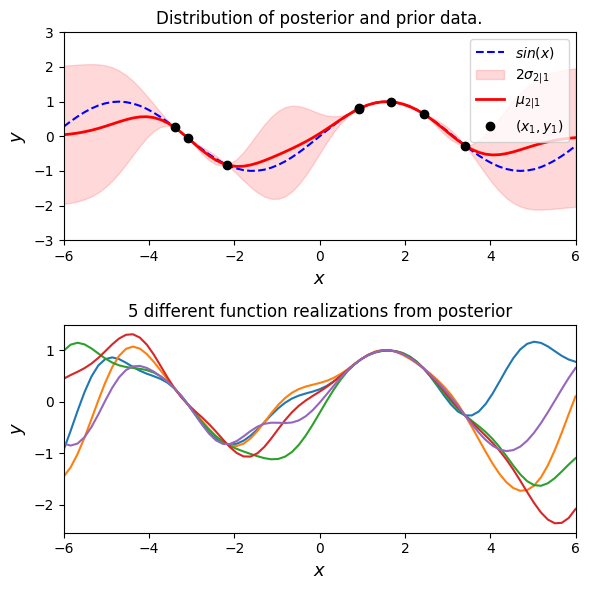

In [149]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [139]:
x1 = torch.randn(500, 102)
x2 = torch.randn(1, 102)

In [140]:
compute_variance(x2, x1)

LinAlgError: Matrix is singular.

In [ ]:
compute

In [114]:
a = torch.randn(1,102)

In [115]:
b = torch.randn(500, 102)

In [116]:
a @ b

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x102 and 500x102)